In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [6]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

In [131]:
#Now it turns out my sample is very biased
#about 1% of the dm particles have associated stellar mass
#
#Apparently you can pass a bias to the network and it will
#work with that
#
#First load the data

f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')
f_stars = h5py.File('../m12i_res_7100_cdm/output/snapshot_600.stars.hdf5')

pos_halo = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo = f_halo['velocity'][:]

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos = pos_halo[host_id]
host_vel = vel_halo[host_id]

f = h5py.File('DM_data_w_stars_training.hdf5')

coords = f['PartType1']['Coordinates'][:]
vel = f['PartType1']['Velocities'][:]
mass_ratio = f['PartType1']['Mass_Ratio'][:]

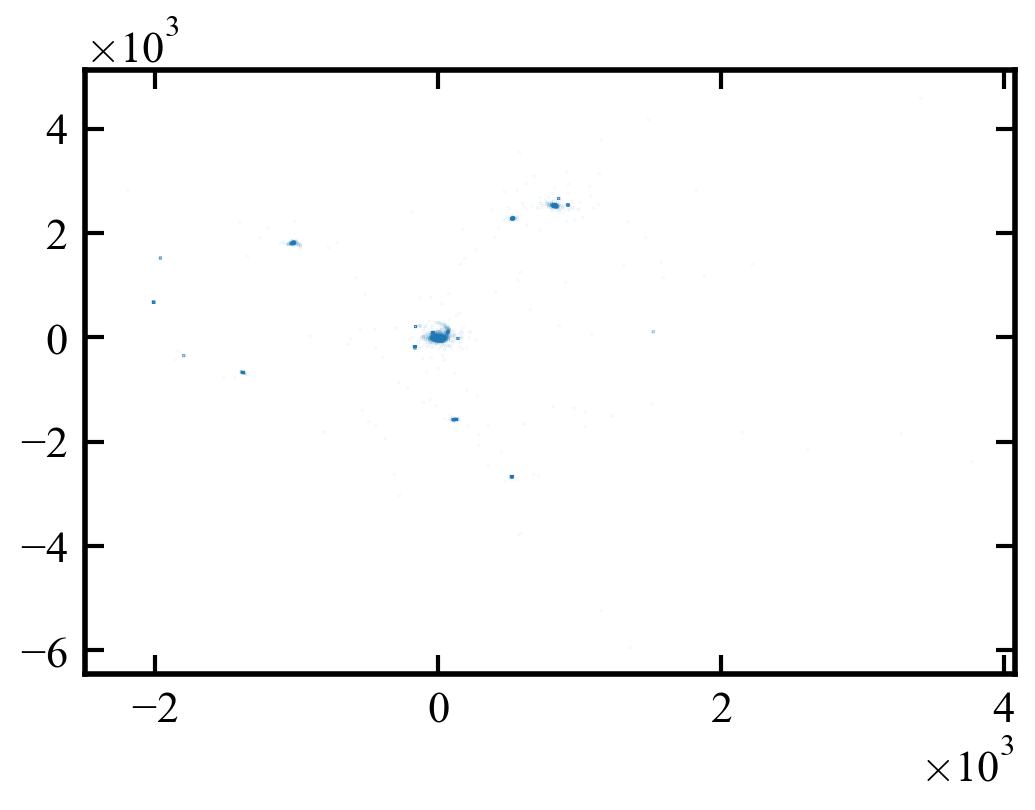

In [137]:
f_stars = h5py.File('../m12i_res_7100_cdm/output/snapshot_600.stars.hdf5')
h = 0.702
star_coords = f_stars['PartType4']['Coordinates'][:]/h

plt.scatter(star_coords[:,0][::100]-host_pos[0],
            star_coords[:,1][::100]-host_pos[1],marker='.',s=0.001)
plt.show()

1001956


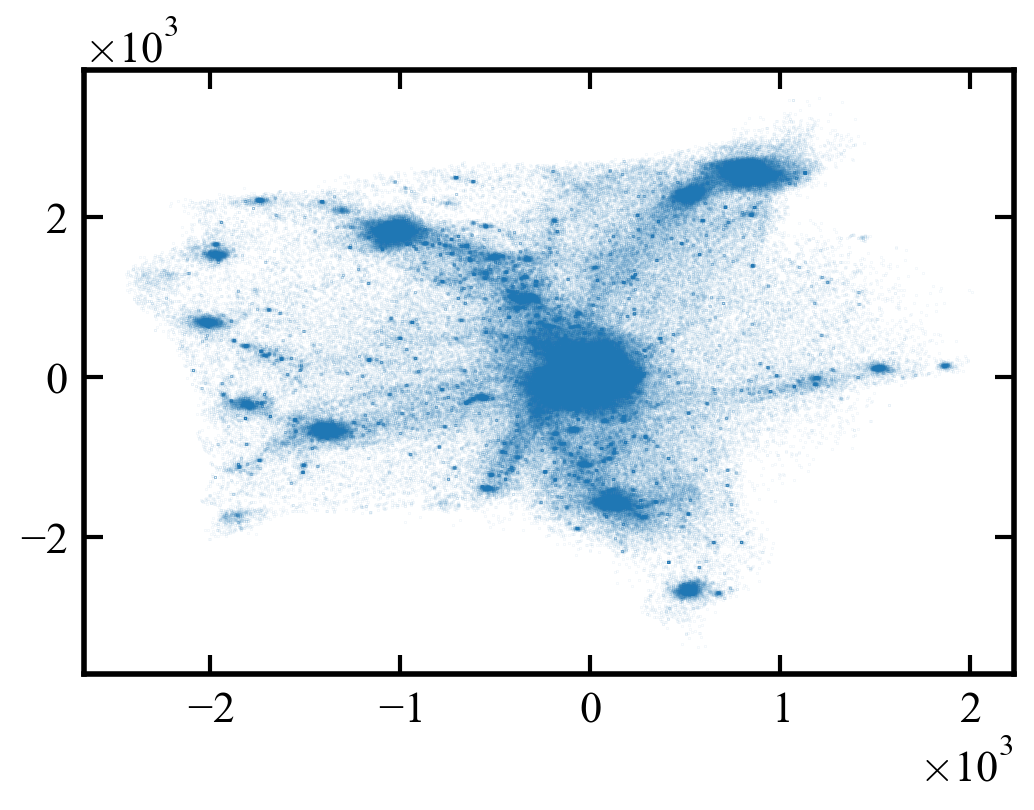

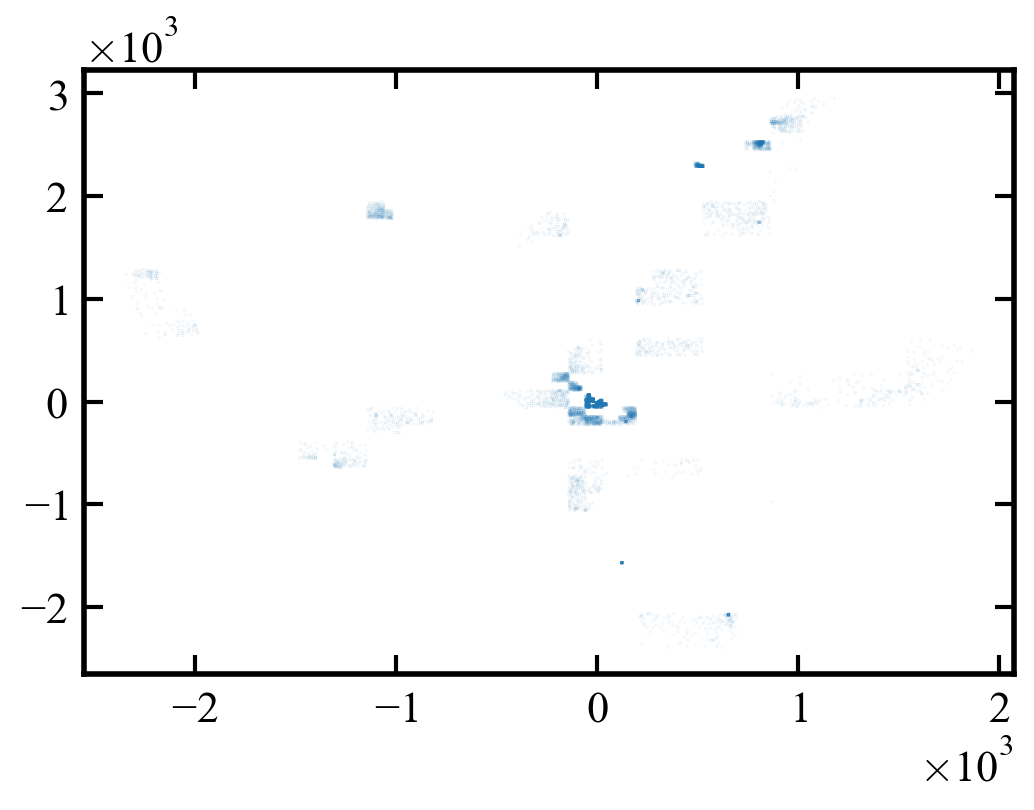

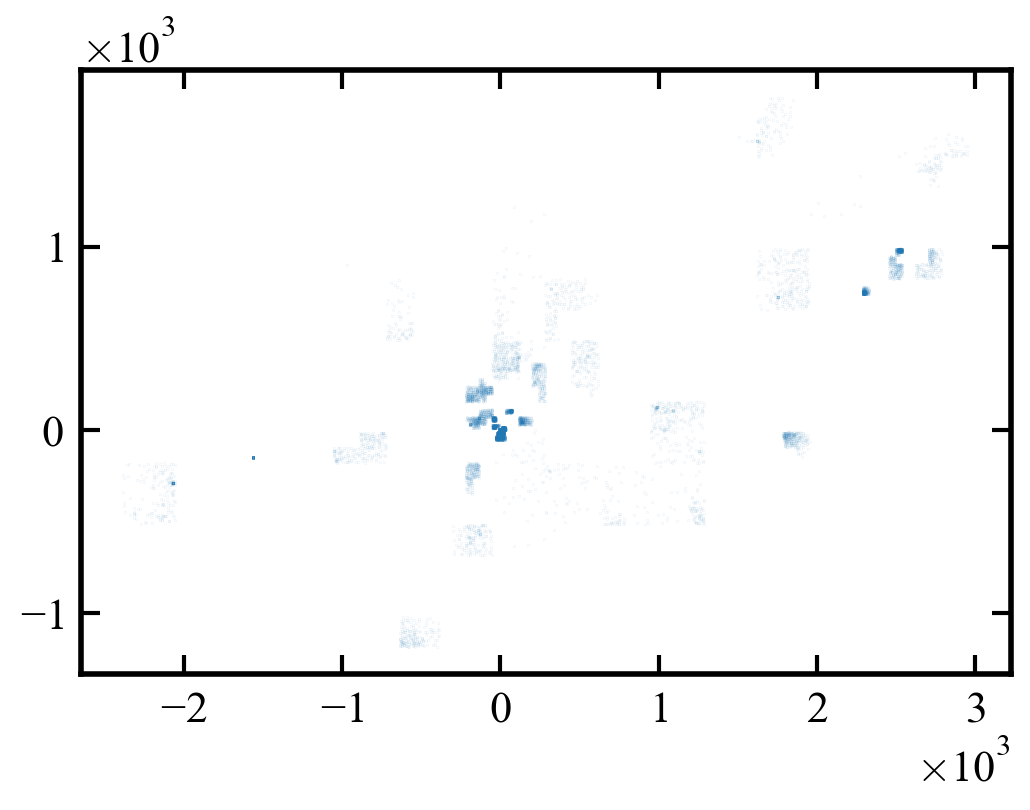

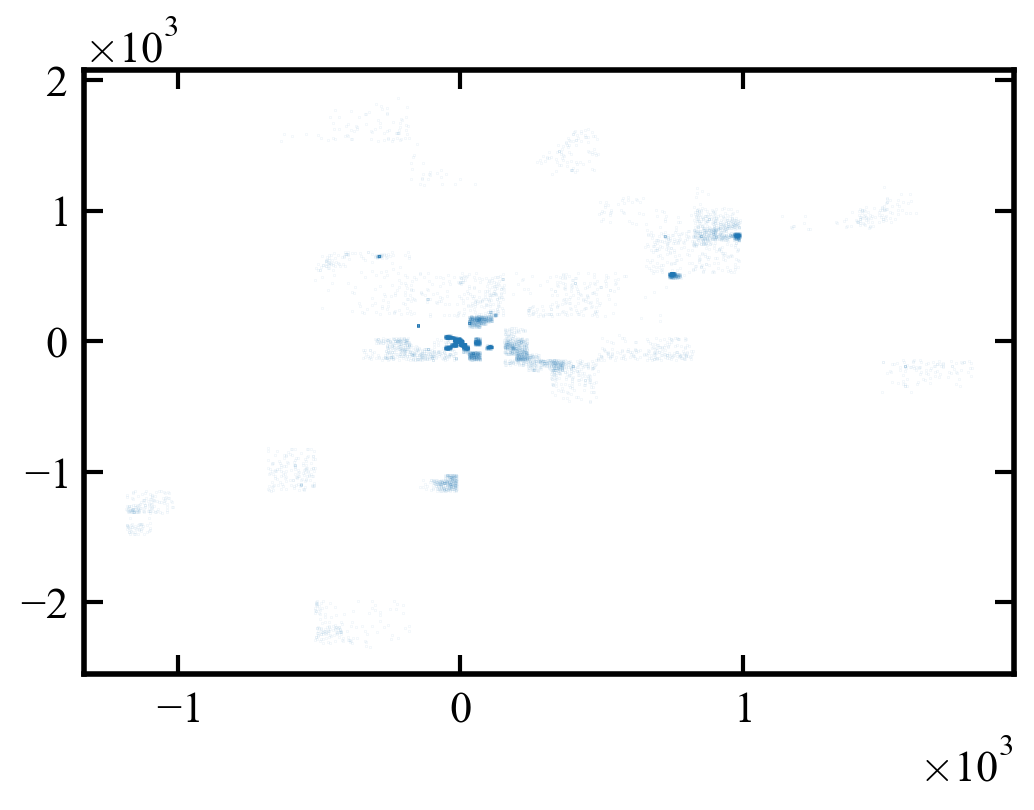

In [132]:
train_set_mask = mass_ratio>0.0
print np.sum(train_set_mask)
train_coords = coords[train_set_mask]

plt.scatter(coords[:,0][::100]-host_pos[0],
            coords[:,1][::100]-host_pos[1],marker='.',s=0.001)
plt.show()

plt.scatter(coords[:,0][train_set_mask][::100]-host_pos[0],
            coords[:,1][train_set_mask][::100]-host_pos[1],marker='.',s=0.001)
plt.show()


plt.scatter(coords[:,1][train_set_mask][::100]-host_pos[1],
            coords[:,2][train_set_mask][::100]-host_pos[2],marker='.',s=0.001)
plt.show()

plt.scatter(coords[:,2][train_set_mask][::100]-host_pos[2],
            coords[:,0][train_set_mask][::100]-host_pos[0],marker='.',s=0.001)
plt.show()

In [6]:
diff_coord = coords-host_pos
diff_vel = vel - host_vel

dist  = np.linalg.norm(diff_coord,axis=1)
gal_select = (dist<100.0)

diff_coord_gal = diff_coord[gal_select]
diff_vel_gal = diff_vel[gal_select]
mass_ratio_gal = mass_ratio[gal_select]

phase_space_coords =  np.concatenate((diff_coord_gal,diff_vel_gal),axis=1)

print len(dist)
print len(mass_ratio_gal)

print (np.sum(mass_ratio_gal>0.0))

70514272
15489004
342360


In [30]:
X_train, X_test, y_train, y_test = train_test_split(phase_space_coords,mass_ratio_gal,
                                                    test_size=0.999,random_state=102)

In [46]:
print len(y_train), len(y_test), len(mass_ratio_gal)


y_all = np.array((mass_ratio_gal!=0),dtype=int)

neg, pos = np.bincount(y_all)

print neg, pos

initial_bias = np.log([float(pos)/float(neg)])

print initial_bias

154890 15334114 15489004
15146644 342360
[-3.78967145]


In [31]:
y_train_classifier  = np.array((y_train!=0),dtype=int)

151485 3405
[-3.79524167]


In [56]:
def build_model(output_bias=None):
    
    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
    
    output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([layers.Flatten(input_shape=(6,)),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(64, activation='relu'),
                              layers.Dropout(0.5),
                              layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
                             ])
    
    optimizer = keras.optimizers.Adam(lr=1e-3)
    loss  = tf.keras.losses.BinaryCrossentropy()
    
    model.compile(loss=loss,optimizer=optimizer,metrics=METRICS)
    
    return model

print 'I guess we build this thing'

model = build_model(output_bias=initial_bias)

I guess we build this thing


In [58]:
EPOCHS = 1000
BATCH_SIZE=2048
history = model.fit(X_train, y_train_classifier, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

In [59]:
y_test_classifier  = np.array((y_test!=0),dtype=int)

model.evaluate(X_test,y_test_classifier,batch_size=BATCH_SIZE,verbose=2)

15334114/15334114 - 17s - loss: 0.0384 - tp: 150140.0000 - fp: 32183.0000 - tn: 14962976.0000 - fn: 188815.0000 - accuracy: 0.9856 - precision: 0.8235 - recall: 0.4429 - auc: 0.9787


[0.03837270337137236,
 150140.0,
 32183.0,
 14962976.0,
 188815.0,
 0.98558784,
 0.8234836,
 0.44294965,
 0.9787303]

In [60]:
y_predict = model.predict(X_test)

In [72]:
len(y_predict)
np.max(y_predict)

np.sum(y_predict>0.025)

1234105

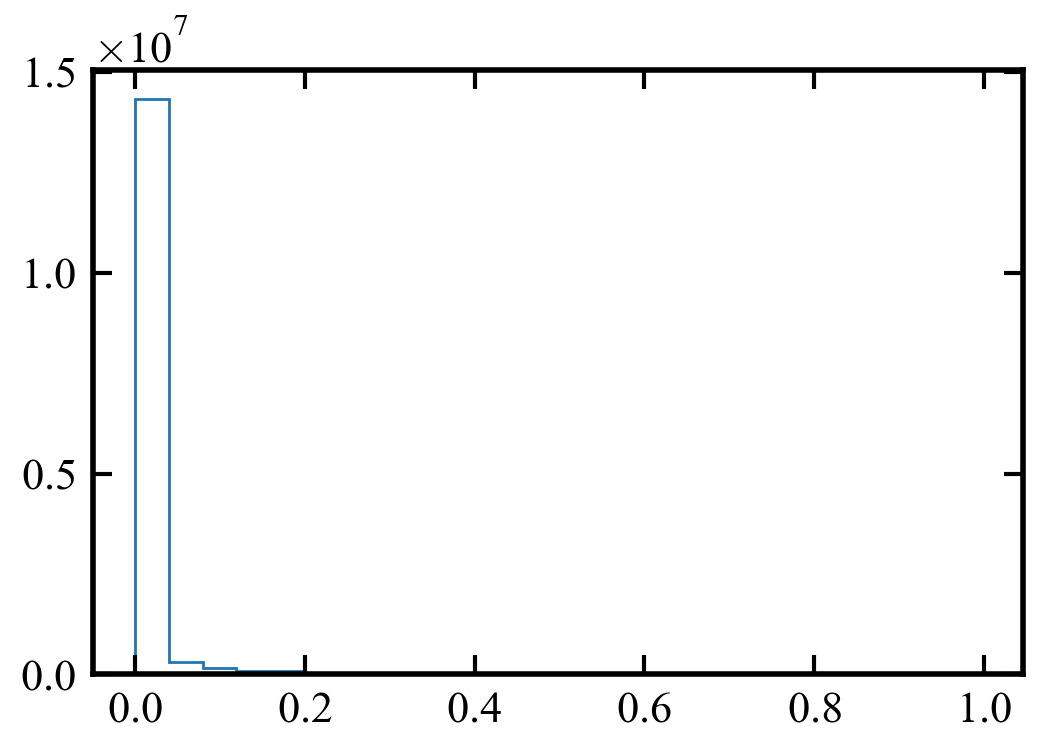

In [62]:
plt.hist(y_predict,bins=25,histtype='step')
plt.show()

In [7]:
#alright now I'm going to try to apply to data

f = h5py.File('../halo_1107_Z13/halo_1107_Z13_particles.hdf5')

h = 0.675

parts = f['PartType1']
coords = parts['Coordinates'][:]/h
vel = parts['Velocities'][:]
mass= parts['Masses'][:]*1.0e10/h
ids = parts['ParticleIDs'][:]

host_cen = np.array([37.53820323, 34.52403051, 37.02327211])*1000.0/h
host_vel = np.array([ 57.161152, -83.112122, -17.277088])

coord_diff = np.subtract(coords,host_cen)
vel_diff = np.subtract(vel,host_vel)

In [8]:
print host_cen
print coords

[55612.15293333 51146.71186667 54849.29201481]
[[36441.96973376 35014.35929846 34880.51071779]
 [36442.1859967  35014.19091147 34880.78989903]
 [36442.22599593 35014.23654645 34880.76989525]
 ...
 [37538.13372781 33278.21164545 40089.12133394]
 [37543.17173479 33273.85900792 40096.38128556]
 [37539.42970605 33273.84825119 40091.1226565 ]]


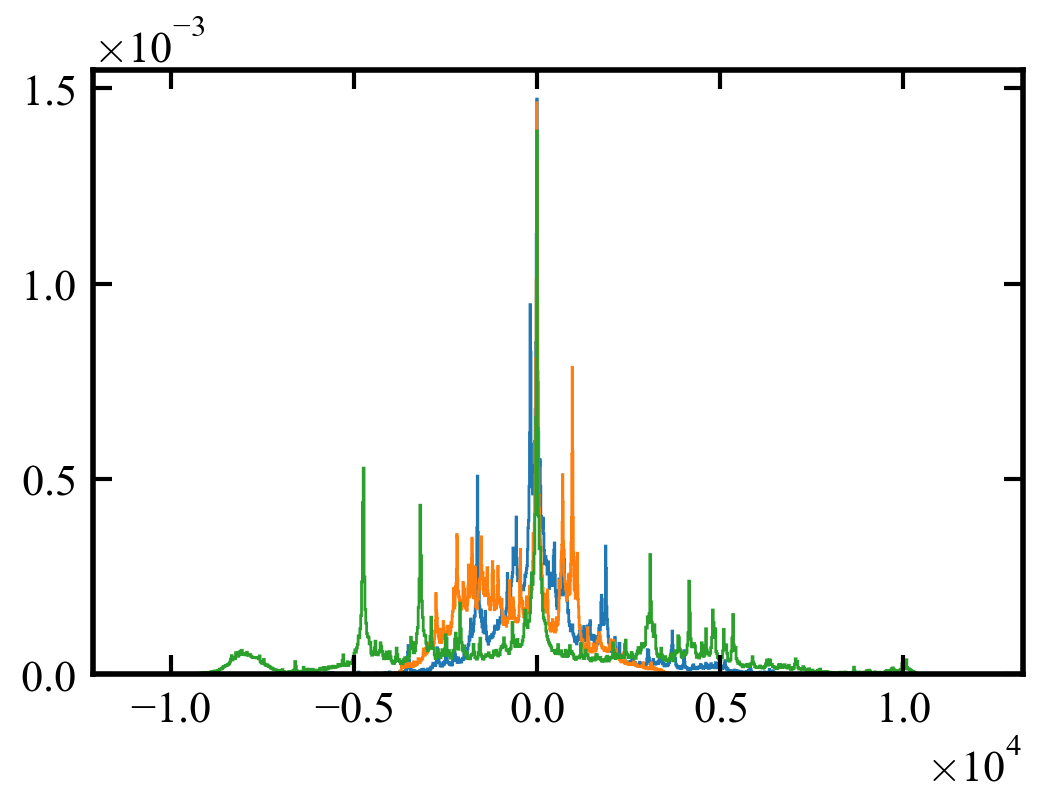

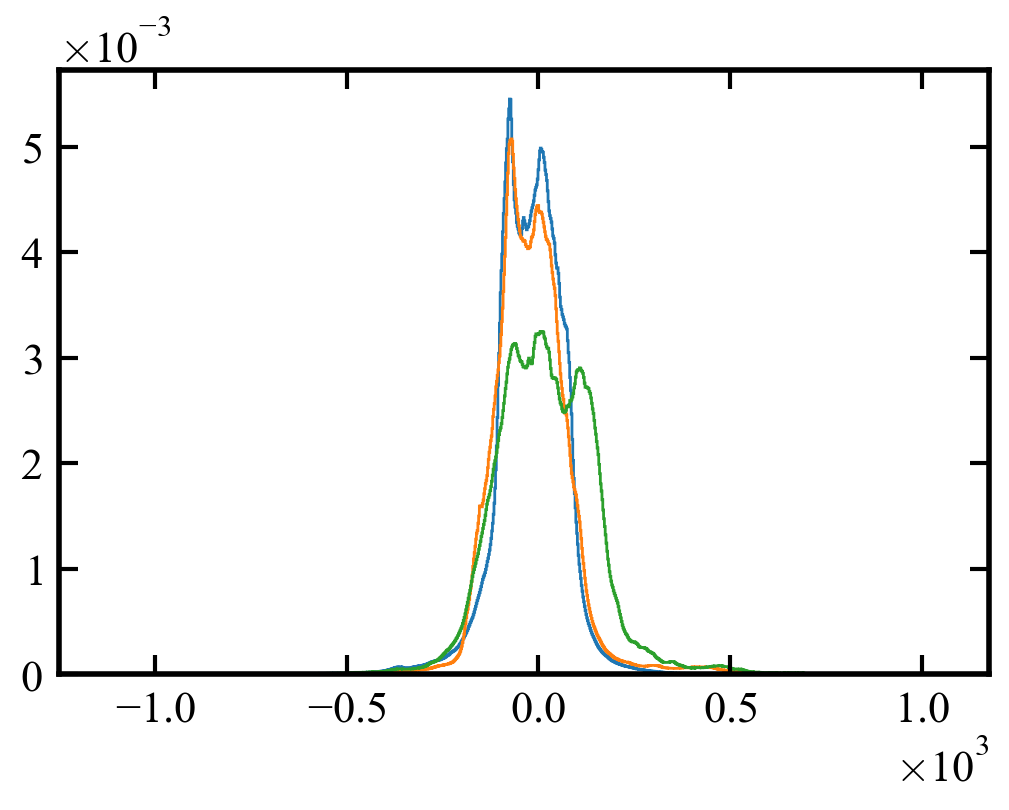

In [91]:
plt.hist(coord_diff[:,0],bins=1000,histtype='step',normed=True)
plt.hist(coord_diff[:,1],bins=1000,histtype='step',normed=True)
plt.hist(coord_diff[:,2],bins=1000,histtype='step',normed=True)
plt.show()

plt.hist(vel_diff[:,0],bins=1000,histtype='step',normed=True)
plt.hist(vel_diff[:,1],bins=1000,histtype='step',normed=True)
plt.hist(vel_diff[:,2],bins=1000,histtype='step',normed=True)
plt.show()

In [92]:
phase_space_coords = np.concatenate((coord_diff,vel_diff),axis=1)
model = tf.keras.models.load_model('./saved_models/Classifier_biased_sigmoid.h5')

model_output = model.predict(phase_space_coords)

In [88]:
print(host_cen)

print(coords)

print(np.mean(coords[:,0]),np.mean(coords[:,1]),np.mean(coords[:,2]))

[37538.20323 34524.03051 37023.27211]
[[53980.1062565  51865.44111755 51667.17629653]
 [53980.42659858 51865.1916923  51667.5898371 ]
 [53980.48584792 51865.25928966 51667.56020627]
 ...
 [55603.8123653  49293.75151155 59382.49345865]
 [55611.27497376 49287.30411483 59393.24734937]
 [55605.73204867 49287.28818129 59385.45794179]]
(55821.40964556275, 50707.7707181081, 54626.012193056704)


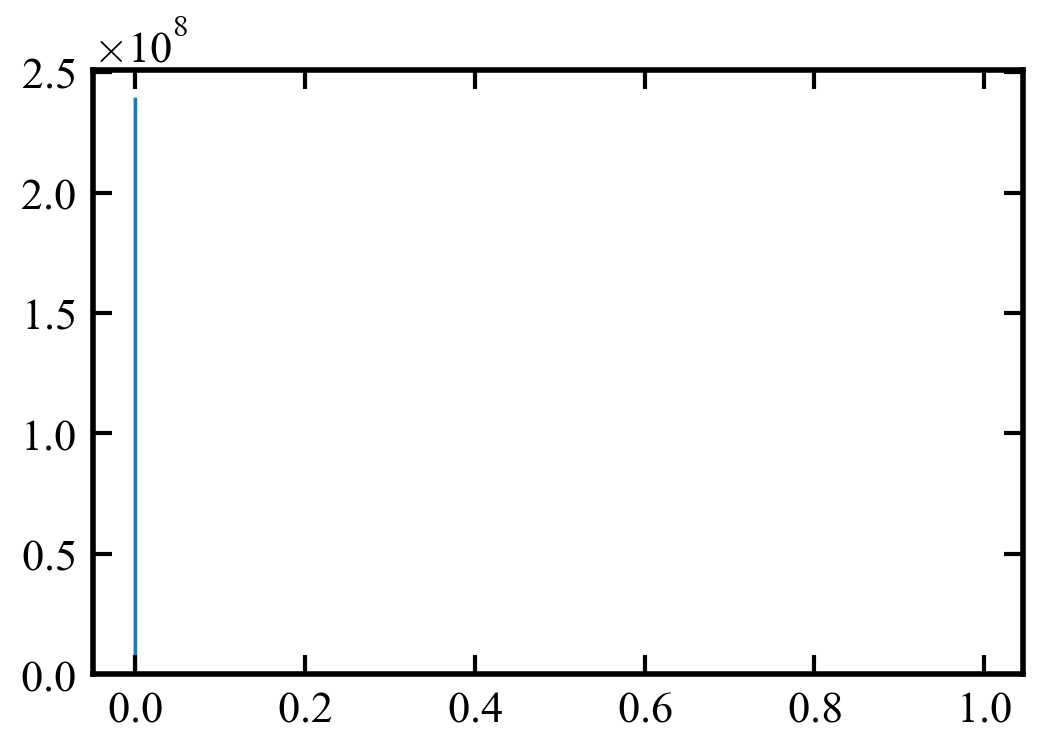

In [96]:
plt.hist(model_output,bins=1000,histtype='step')
plt.show()

In [106]:
print np.sum(model_output>0.0)/float(len(model_output))
print np.sum(model_output>0.001)/float(len(model_output))
print np.sum(model_output>0.0)

0.04357664891124698
0.009226869322723997
10504747


[[55600.45087175 51148.00843881 54848.81838974]
 [55600.59798821 51147.91797065 54848.95248793]
 [55600.7176736  51147.9817152  54848.84248703]
 ...
 [55613.1468579  51147.98648685 54848.7938431 ]
 [55613.22437043 51147.92815757 54848.62706479]
 [55613.05541249 51147.93396096 54848.74625856]]


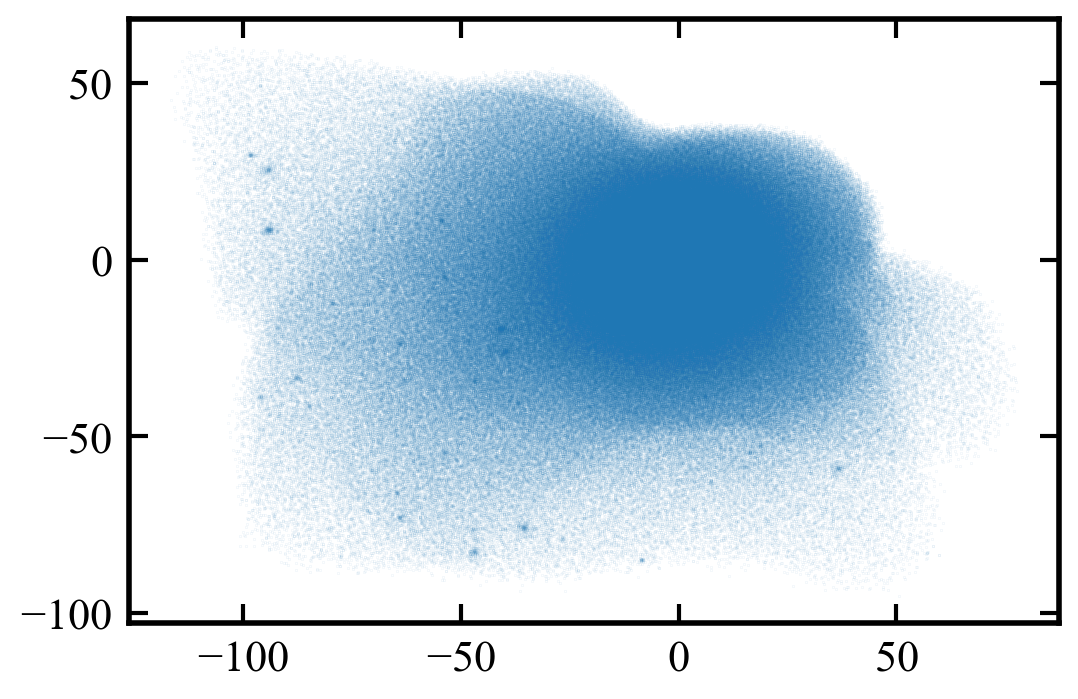

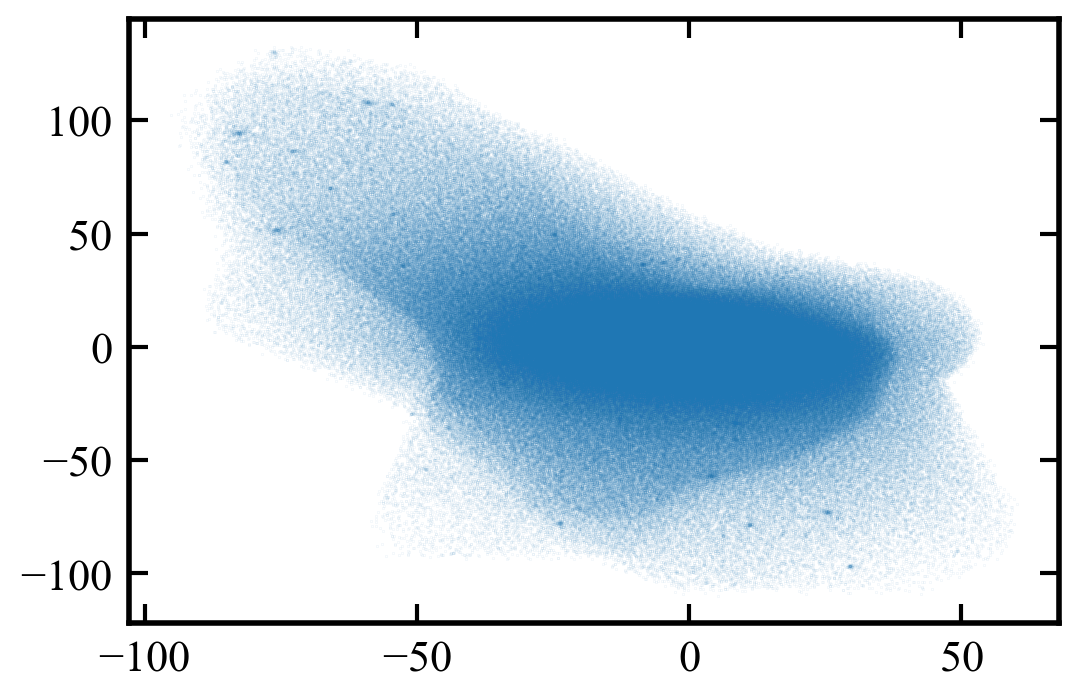

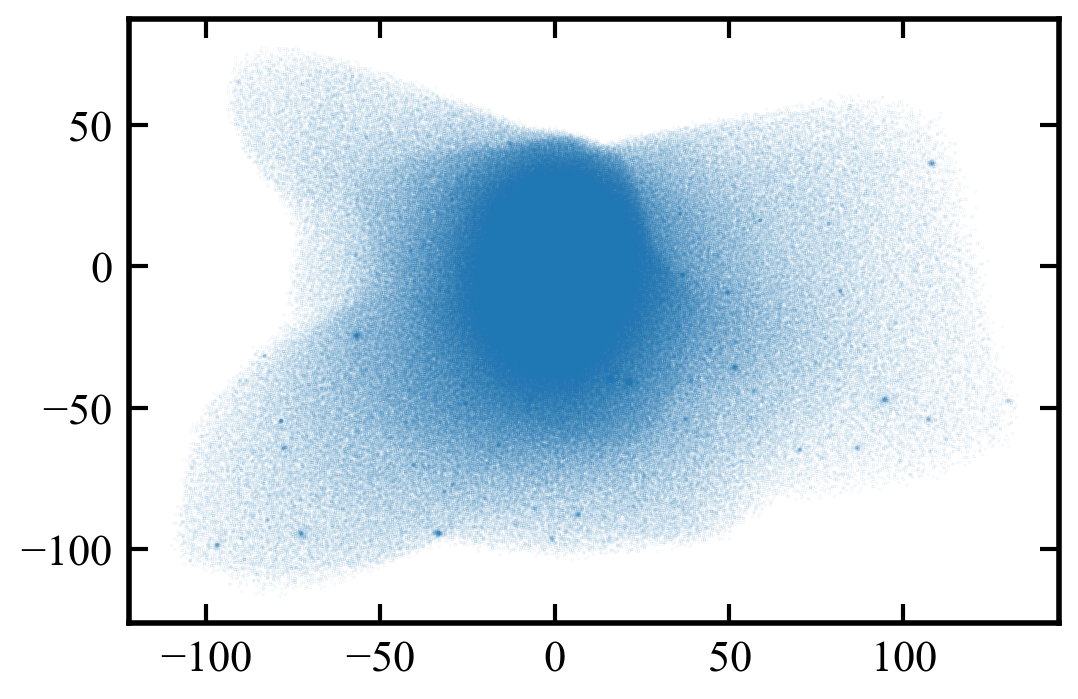

In [126]:
mock_star_mask = np.ndarray.flatten((model_output>0.0))

print np.ndarray.flatten(mock_star_mask)

dark_part_coords = coords[mock_star_mask]

print dark_part_coords

plt.scatter(dark_part_coords[:,0][::10]-host_cen[0],
            dark_part_coords[:,1][::10]-host_cen[1],marker='.',s=0.001)
plt.show()

plt.scatter(dark_part_coords[:,1][::10]-host_cen[1],
            dark_part_coords[:,2][::10]-host_cen[2],marker='.',s=0.001)
plt.show()

plt.scatter(dark_part_coords[:,2][::10]-host_cen[2],
            dark_part_coords[:,0][::10]-host_cen[0],marker='.',s=0.001)
plt.show()

In [130]:
from scipy.spatial import cKDTree

x, y = np.mgrid[0:5, 2:8]

print x, y
print np.c_[x.ravel(),y.ravel()]

tree = cKDTree(np.c_[x.ravel(),y.ravel()])

dd, ii = tree.query([[0,0],[2.1,2.9]], k = 1)

print dd, ii

[[0 0 0 0 0 0]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [4 4 4 4 4 4]] [[2 3 4 5 6 7]
 [2 3 4 5 6 7]
 [2 3 4 5 6 7]
 [2 3 4 5 6 7]
 [2 3 4 5 6 7]]
[[0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [2 2]
 [2 3]
 [2 4]
 [2 5]
 [2 6]
 [2 7]
 [3 2]
 [3 3]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [4 2]
 [4 3]
 [4 4]
 [4 5]
 [4 6]
 [4 7]]
[2.         0.14142136] [ 0 13]
